# Solutions for Lab Sheet 7 (COM3502-4502-6502 Speech Processing)

This lab sheet is part of the lecture COM3502-4502-6502 Speech Processing at the [University of Sheffield](https://www.sheffield.ac.uk/ "Open web page of The University of Sheffield"), School of [Computer Science](https://www.sheffield.ac.uk/cs "Open web page of School of Computer Science, University of Sheffield").

It is probably easiest to open this Jupyter Notebook with [Google Colab](https://colab.research.google.com/notebooks/intro.ipynb#recent=true "Open in Google Colab") since GitHub's Viewer does not always show all details correctly. <a href="https://colab.research.google.com/github/sap-shef/SpeechProcesssingLab/blob/main/Lab-Sheets/Lab-Sheet-7.ipynb"><img align="right" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open Notebook in Google Colab" title="Open and Execute the Notebook directly in Google Colaboratory"></a>

Please put questions, comments and correction suggestions in the [Blackboard](https://vle.shef.ac.uk) discussion board or send an email to [n.ma@sheffield.ac.uk](mailto:n.ma@sheffield.ac.uk).

<div class="alert alert-block alert-success" id='ILOs'>
<strong>Intended Learning Objectives (ILOs):</strong><br>
    
After completing this Jupyter Notebook you should
    
<ul>
<li>have familiarised yourself with the concept of the <a href="https://en.wikipedia.org/wiki/Overlap%E2%80%93add_method"><code>Overlap-add algorithm</code></a>
</li> 
<li>Be able to implement your own Overlap-add function
</li>    
<li>Understand the concept of <a href="https://wiki.aalto.fi/display/ITSP/Windowing"><code>Perfect Reconstruction</code></a> and the Princen-Bradley criteria
</li>
<li>familiarise yourself with the basic use of the <code>Python</code> libraries 
    <ul>
    <li><a href="https://numpy.org/doc/stable/index.html"><code>Numpy</code></a> commands 
        <a href="https://numpy.org/doc/stable/reference/generated/numpy.pad.html"><code>pad()</code></a>,
        <a href="https://numpy.org/doc/stable/reference/generated/numpy.append.html"><code>append()</code></a>,
        <a href="https://numpy.org/doc/stable/reference/generated/numpy.hamming.html"><code>hamming()</code></a>,
        <a href="https://numpy.org/doc/stable/reference/generated/numpy.hanning.html"><code>hanning()</code></a>,
        <a href="https://numpy.org/doc/stable/reference/generated/numpy.blackman.html"><code>blackman()</code></a>,
        etc.
    </li>
    <li><a href="https://matplotlib.org/"><code>Matplotlib</code></a> for graphical output (like 
        <a href="https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.gca.html"><code>gca()</code></a>, 
        <a href="https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.gcf.html"><code>gcf()</code></a>, 
        etc.)
    </li>
    </ul>
</li>
</ul>
</div>

In [54]:
# Let's do the ususal necessary and nice-to-have imports
%matplotlib inline
import matplotlib.pyplot as plt  # plotting
import seaborn as sns; sns.set() # styling ((un-)comment if you want)
import numpy as np               # math

# imports we need in addition for this lab sheet
from IPython import display as ipd
import scipy.signal as sig
import soundfile as sf
from scipy.io.wavfile import read as wavread

<br>
<a id='task_1'></a>
<div class="alert alert-block alert-info">
    
**Task 1:**
    
<ul>
<li> 
    Load a WAVE file containing speech, e.g. <code>https://staffwww.dcs.shef.ac.uk/people/n.ma/comx502/speech_8kHz_murder.wav</code> and load it into a variable <code>s</code>.
</li>
    <li> 
    Generate a signal of white noise of the same length as your speech signal and load it into a variable <code>n</code>. Refer to <a href="https://colab.research.google.com/github/sap-shef/SpeechProcesssingLab/blob/main/Lab-Sheet-Solutions/Lab-Sheet-3-Solution.ipynb#scrollTo=b02cc2bd">Lab Sheet 3</a> for help. Normalise the amplitude of the noise signal to have an ampliude of $0.2$ (to avoid that it is too loud).
</li>
  <li>   
    Create a microphone signal $y[k] = s[k]+n[k]$ as shown in the schematic below.

<img id='FigNRSingleChannelBasic' src="https://staffwww.dcs.shef.ac.uk/people/S.Goetze/book/Chp5SignalEnhancementNR/images/NRSingleChannelBasic-web.png" align="center"/>
      <center><span style="font-size:smaller">
    <b>Fig. 1:</b> Noise reduction filter $h[k]$ aiming to reduce the noise component $n[k]$ from the noisy microphone signal $y[k]$ to obtain an estimate of the clean speech signal $\hat{s}[k]$.
</span></center>
    </li> 
</ul>
</div>

In [30]:
# load speech wave into variable
s_file_name = 'speech_8kHz_murder.wav'
!curl https://staffwww.dcs.shef.ac.uk/people/n.ma/comx502/{s_file_name} -o {s_file_name} 

s, fs = sf.read(s_file_name)
print('File "' + s_file_name + '" loaded. Its sampling rate is ' + str(fs) + ' Hz.')

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  328k  100  328k    0     0  3325k      0 --:--:-- --:--:-- --:--:-- 3355k
File "speech_8kHz_murder.wav" loaded. Its sampling rate is 8000 Hz.


In [31]:
# generate Gaussian white noise
n = np.random.normal(size=len(s))
# normalise noise to amplitude 1
n = n / np.max(np.abs(n))
# and now to a maximum amplitude of 0.2
n = n * 0.2

As done before we can listen to the signals:

In [32]:
# listen to the speech file (if you want)
ipd.Audio(s, rate=fs)

In [33]:
# listen to the noise file (if you want)
ipd.Audio(n, rate=fs)

In [ ]:
# create noisy microphone signal as depicted in Fig. 1
y = s + n

In [66]:
# listen to the modelled microphone signal (if you want)
ipd.Audio(y, rate=fs)

or we could visualise then by plotting.

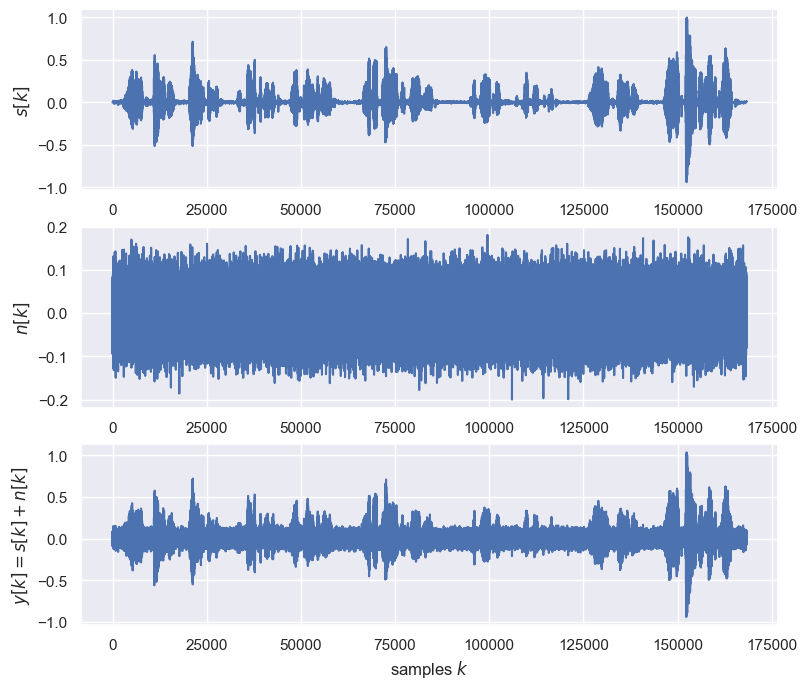

In [53]:
plt.figure(figsize=(9,8))
plt.subplot(3,1,1)
plt.plot(s)
plt.ylabel('$s[k]$')
plt.subplot(3,1,2)
plt.plot(n)
plt.ylabel('$n[k]$')
plt.subplot(3,1,3)
plt.plot(y)
plt.ylabel('$y[k]=s[k]+n[k]$')
plt.xlabel('samples $k$');

From listening to the sound files as well as from comparing clean speech signal $s[k]$ and noisy signal $y[k]$ in the figure above, the effect of the noise should be obvious.

# Overlap-add Processing

When processing signals with long duration, it is common practise to do so by splitting the long signal into a series of shorter segments or chunks, a.k.a. frames. This is primarily for three reasons:

<ul>
<li> First, dealing with the full signal 'in one go' might be impractical due to constraints in computational memory (especially if you have to implement algorithms on ressource-limited hardware, such as r.g. microcontrollers). 
</li> 
<li> Second, to attain useful inference from operations such as the discrete Fourier Transform, it is assumed that the signal under scrutiny is time invariant (i.e its statistical properties do not vary with time). This is only typically true when analysing signals over short time frames. 
</li> 
<li> Third, for streaming applications involving block processing, such as a live spectrogram, adaptive noise reduction for a phone call, you may be interested in the result whilst still obtaining input data.
</li>
</ul>

A simple algorithm to perform such chunk-wise processing is the [Overlap-Add method](https://en.wikipedia.org/wiki/Overlap%E2%80%93add_method).

The Overlap-Add method can be broken down into 3 stages:
<ul>
<li> 
    <strong>Segmentaion</strong> - Extract signal chunks (frames) of length $L$ by iteratively applying a windowing function, such as a Hanning window, to each chunk with each chunk overlapping by a number of $M$ samples. $M$ is often chosen to be $L/2$ in speech processing, i.e the overlapping fraction is that of the window length halved.
</li> 
<li>
    <strong>Processing</strong> - Each windowed chunk is processed independently, by convolving with a FIR filter for example.
</li>
<li>
    <strong>Reconstruction</strong> - The processed chunks are 'added' back together sequentially to retain each chunk's relative position in the original signal.
</li>
</ul>
    

The process is described mathematically below where a long signal, $x[k]$, is to be convolved with a finite impulse response filter, $h[k]$.  

1.&emsp;Applying a window function centered at the $i$th sample with window $w[k]$ of length $L$, whose value is 0 beyond $-L/2$ and $+L/2$:

\begin{equation}
x_i[k] = x[k]w^L_i[k]
\tag{1}
\end{equation}

2.&emsp;Fragmentation of signal:

\begin{equation}
x[k] = x_0[k] + x_1[k] + x_2[k] + ... 
\tag{2}
\end{equation}

<img id='FigBlockProcessing' src="https://staffwww.dcs.shef.ac.uk/people/S.Goetze/book/Chp2Fundamentals/images/signals-block-processing-web.png" align="center" width="700px"/>
      <center><span style="font-size:smaller">
    <b>Fig. 2:</b> Generating signals chunks / frames from longer signal.
</span></center>

[Fig. 2](#FigBlockProcessing) illustrates the split of the sequence $x[k]$ in the upper panel into chunks / frames $x_i[k]$. The windows $w_i[k]$ for each chunk $i$ are illustrated by dashed red lines. 

3.&emsp;Apply filter to fragmented signal 

$$
y[k]=\sum_{i=0}^{N-1}x_{k-i}\cdot h[i]
$$  

4.&emsp;Use the distributive property of convolvution to formulate as blockwise:
\begin{align*}
y[k]=&\sum_{i=0}^{N-1}x[k-i]h[i]
\\=&\sum_{i=0}^{N-1}(x_{0}[k-i]+x_{1}[k-i]+...)\cdot h[i]
\\=&\sum_{i=0}^{N-1}x_{0}[k-i]\cdot h[i]+\sum_{i=0}^{N-1}x_{1}[k-i]\cdot h[i] + ...
\\=&\:\mathrm{IFFT}\left \{ x_{0}[n]h[n]\right \} + \mathrm{IFFT}\left \{ x_{1}[n]h[n]\right \} +...
\\=&\: y_{0}[k] + y_{1}[k] + ...
\end{align*}

Since speech signals are time variant in nature, it is beneficial to utilise the Overlap-Add algorithm during the processing of them. This is based on the assumption that, heuristically speaking, fragmented speech present in each chunk may roughly represents a phoneme, where the signal is assumed to be time invariant.



<br>
<a id='task_2'></a>
<div class="alert alert-block alert-info">
    
**Task 2: Perform windowing on your modelled microphone signal.**
    
<ul>
<li> Extract a short temporal range from your noisy microphone signal $y[k]$; e.g. $\approx 0.5$ second of audio.
</li>     
<li>
    Finish the below function to iterate through said range applying a windowing function from the numpy library to each iteration. 
</li>
<li>
       Have the function return a list or np.array() all extracted chunks/frames, with each chunk padded with zeros so that all chunks are of the same length as the original input.
</li>
<li>
       Test your function with the 'Blackman' filter.
</li>
</ul>
</div>

In [55]:
def get_windowed_chunks(sample, chunk_length = 0.03, fs = 8000, window_choice = 'Blackman'):
    """
    Extracts windowed segments from a signal for a given chunk/frame length using a windowing
    function from the numpy library.
    
    Input:
        sample: list or np.array
            input signal to be split into chunks/frames
        chunk_length: float
            desired window length in seconds
        fs: int
            sampling frequency of signal
        window_choice: str 
            windowing function to use, one of: Blackman, Hamming, Hanning
    Output:
        list of np.arrays
        windowed chunks/frames
    
    Example:
       list_of_windows = get_windowed_chunks(sample, chunk_length = 0.025, fs=8000, window_choice = 'Hanning')
    """
    L_2 = chunk_length/2*fs
    window_centres = np.arange(L_2, len(sample), L_2)
    windowedFrames = []
    for c in window_centres:
        fragment = sample[int(c-L_2):int(c+L_2)]
        window_funcs = {'Hamming':  np.hamming(len(fragment)), 
                        'Blackman': np.blackman(len(fragment)),
                        'Hanning':  np.hanning(len(fragment))}
        pad_left = int(c-L_2)
        pad_right = len(sample) - int(c+L_2)
        if pad_right < 0:
            pad_right = 0
        windowedFrames.append(np.pad(fragment*window_funcs[window_choice],
                                     (pad_left, pad_right), 'constant'))
    
    return windowedFrames

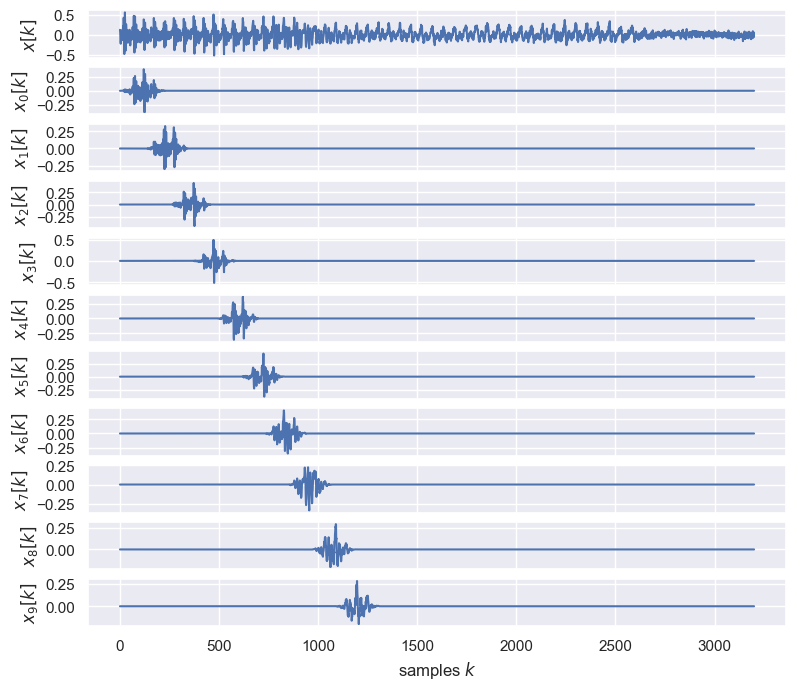

In [56]:
#This figure is being added to the tutorial instead after being polished
T_start = 1.4             # start time of cut-out in seconds
T_end   = 1.8             # end time of cut-out in seconds
sample  = y[int(fs*T_start):int(fs*T_end)]  # cut out of T seconds

# use our function to get the windows signal chunks / frames
windowed = get_windowed_chunks(sample, window_choice = 'Blackman')

# visualise the result
plt.figure(figsize=(9,8))
plt.subplot(11,1,1)
plt.plot(sample)
plt.ylabel('$x[k]$')
for i,w in enumerate(windowed[:10]):
    plt.subplot(11,1,i+2)
    plt.plot(w,label='frame '+str(i) )
    plt.ylabel('$x_'+str(i)+'[k]$')
plt.xlabel('samples $k$');

## Princeton-Bradley Criteria

A desired property of the windowing process used in an Overlap-Add algorithm is that the windowing iteslf should not significantly alter the original signal after signal reconstruction. This is known as the Princeton-Bradley Criteria.


<br>
<a id='task_3'></a>
<div class="alert alert-block alert-info">
    
**Task 3: Princeton-Bradley Criteria**
    
    
<ul>
<li> Try your windowing function with the chunk length of 0.03 seconds and window_choice = 'Blackman'. Do you think the output from this configuration satisfies the Princeton-Bradley Criteria? <br>
    <strong>Hint</strong>: You can test this by simply summing the outputs (windowed segments) and by calculating the difference to the microphone signal before splitting into frames and windowing.
</li>     
<li>
    Do the same using the Hanning window.
</li>
</ul>
</div>

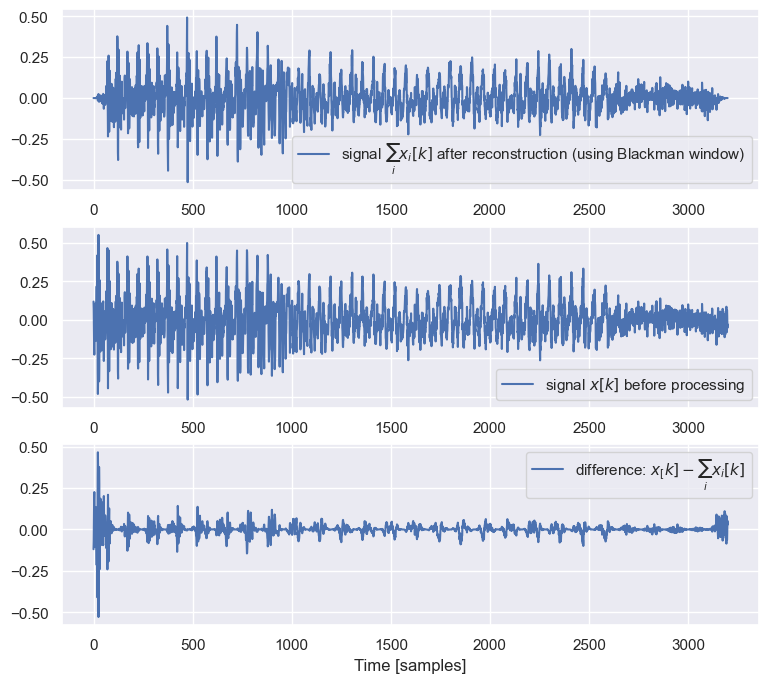

In [57]:
reconstructed = sum([chunk for chunk in windowed])
plt.figure(figsize=(9,8))
plt.subplot(3,1,1)
plt.plot(reconstructed,label='signal $\sum_i x_i[k]$ after reconstruction (using Blackman window)')
plt.legend()
plt.subplot(3,1,2)
plt.plot(sample,label='signal $x[k]$ before processing')
plt.legend()
plt.subplot(3,1,3)
plt.plot(reconstructed-sample,label='difference: $x_[k] - \sum_i x_i[k]$')
plt.legend()
plt.xlabel('Time [samples]');

We see from the figure above that the Blackman window function leads to artifacts when reconstruction the signal again. Note that besides applying a window and resynthesising the signal again we did not apply any actual filtering yet. Therefore we want that the resynthesised signal does not have major differences from our original signal. We can conclude that for using the *Blackman window* the *Princeton-Bradley Criteria* is not fulfilled. Let's check for another window, i.e. the *Hanning window*.

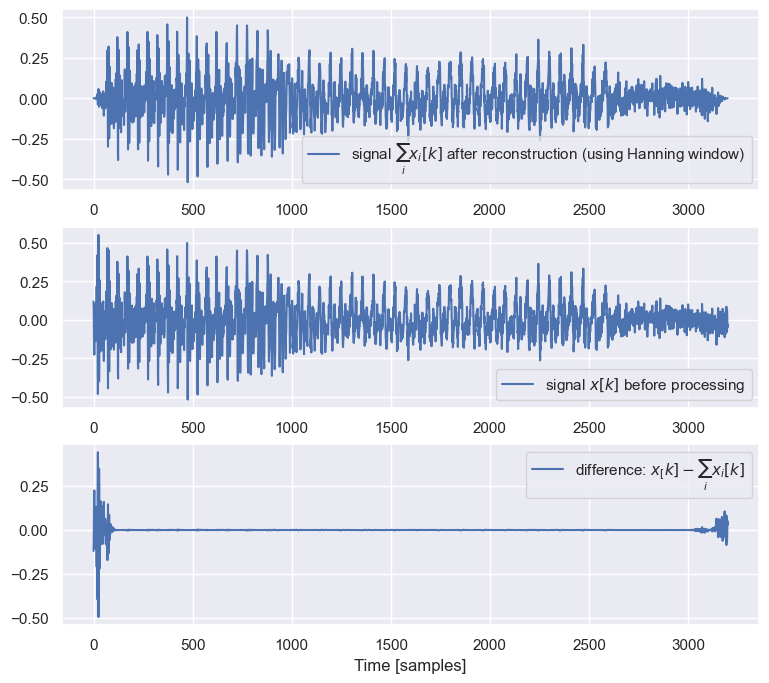

In [58]:
windowed_Hanning = get_windowed_chunks(sample, window_choice = 'Hanning')
reconstructed = sum([w for w in windowed_Hanning])
plt.figure(figsize=(9,8))
plt.subplot(3,1,1)
plt.plot(reconstructed,label='signal $\sum_i x_i[k]$ after reconstruction (using Hanning window)')
plt.legend()
plt.subplot(3,1,2)
plt.plot(sample,label='signal $x[k]$ before processing')
plt.legend()
plt.subplot(3,1,3)
plt.plot(reconstructed-sample,label='difference: $x_[k] - \sum_i x_i[k]$')
plt.legend()
plt.xlabel('Time [samples]');

The figure above shows that, when using the Hanning window) the signal is reconstructed without much errors (with the exeption of the very beginning and very and, which we ignore for the time being). In other words: using the *Hanning window* fulfils the *Princeton-Bradley Criteria*.

## Overlap-Add Function
<br>
<a id='task_1'></a>
<div class="alert alert-block alert-info">
    
**Task 4: Create a function from scratch which implements the Overlap-Add to perform Finite Impulse Response filtering.**
    
<ul>
<li> Create an instance of an FIR filter from the scipy.signal.firwin() and plot the impulse response of the filter.
</li>     
<li> 
   Create a function which: performs windowing (zero padding here is no longer necessary), transforms both the filter and windows to the frequency domain via np.fft.rfft(), and reconstructs the filtered signal.
</li> 
</ul>
</div>

<class 'numpy.ndarray'>


Text(0.5, 0, 'Time [samples]')

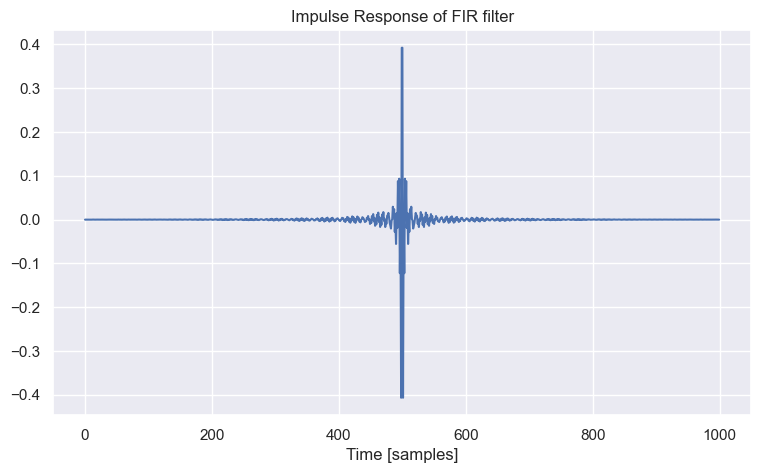

In [ ]:
def overlap_add_filtering(signal, filt, L_I):
    """
    Overlap-Add filtering.
    
    Input:
        signal: np.array or list
            input signal to process
        filt: np.array
            impulse response of FIR filter
        L_I: int
            length of FIR filter
    Output:
        filtered signal
    
    Example:
       overlap_add_filtering(signal, testfilt, 1000)
    """
    bits_to_shift_by = (L_I-1).bit_length() # number of bits necessary to represent in binary
    L_F = 2<<bits_to_shift_by               # length of fourier transform window
    L_W = L_F - L_I + 1 # length of signal to be filtered in single window overlap iteration
    
    filt_F = np.fft.rfft(filt, n=L_F) # filter in frequency domain
    
    windows = [w for w in range(0, len(signal), L_W)]
    
    windows_f = []
    for w in windows:
        signal_w = signal[w:w+L_W] # windowed signal
        signal_w_F = np.fft.rfft(signal_w, n=L_F) #windowed signal in frequency domain
        windows_f.append(np.fft.irfft(signal_w_F*filt_F)) #filtered windowed signal in time domain 
    
    signal_f = np.zeros(len(signal) + L_F)
    for i,n in enumerate(windows):
        signal_f[n:n+L_F] += windows_f[i]
        
    return signal_f[:len(signal)] #truncate to length of original signal


#create instance of FIR filter and plot impulse response

L_I = 1000 # impulse response (number of samples)

# create filter
testfilt = sig.firwin(L_I, [1000, 3900], fs=fs, pass_zero=False) #num_taps (filter order + 1), cutoff frequency 
print(type(testfilt))
plt.figure(figsize = (9,5))
plt.plot(testfilt)
plt.title('Impulse Response of FIR filter')
plt.xlabel('Time [samples]')

In [80]:
#filter with sig.lfilter and record time
%timeit sig.lfilter(testfilt, [1, ], y)
scipy_filtered = sig.lfilter(testfilt, [1, ], y)
%timeit overlap_add_filtering(y, testfilt, L_I)
oa_filtered = overlap_add_filtering(y, testfilt, L_I)

68.7 ms ± 375 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
4.03 ms ± 169 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Text(0.5, 0, 'Time [Samples]')

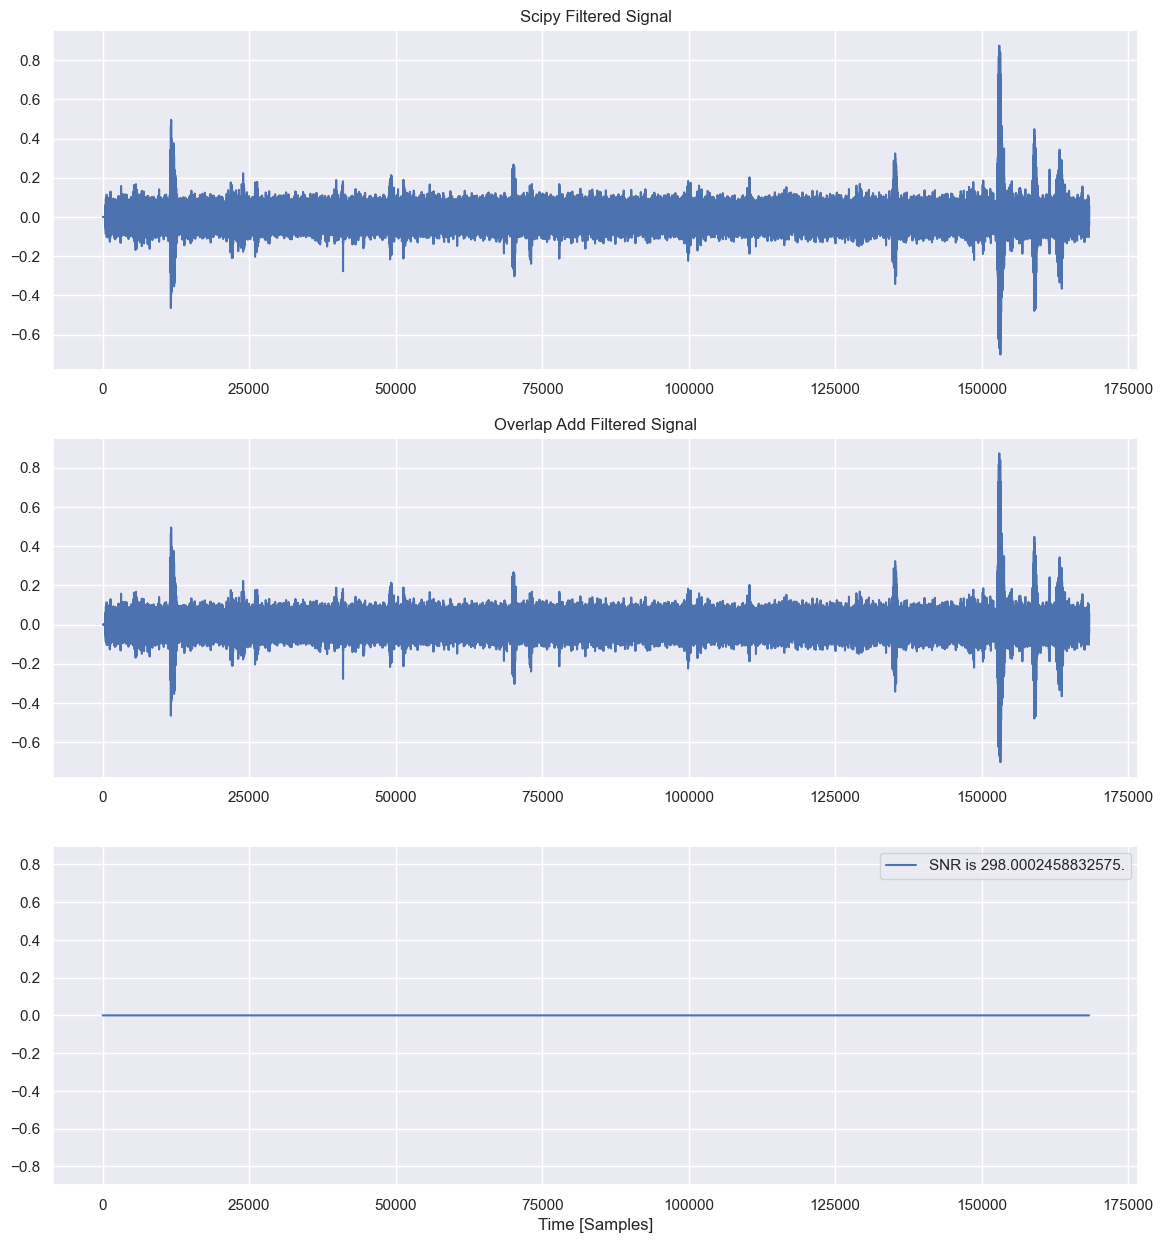

In [86]:
plt.figure(figsize =(14,15))
plt.subplot(3,1,1)
plt.plot(scipy_filtered)
plt.title('Scipy Filtered Signal')
plt.subplot(3,1,2)
plt.plot(oa_filtered)
plt.title('Overlap Add Filtered Signal')
plt.subplot(3,1,3)
sn = 'SNR is {}.'.format(10*np.log10(np.sum(oa_filtered**2)/np.sum((oa_filtered-scipy_filtered)**2)))
plt.plot(oa_filtered-scipy_filtered, label = sn)
plt.ylim(-.9, .9)
plt.legend()
plt.xlabel('Time [Samples]')

## Copyright

This notebook is licensed under [Creative Commons Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) to be used during the lecture COM3502-4502-6502 Speech Processing at the [University of Sheffield](https://www.sheffield.ac.uk/ "Open web page of The University of Sheffield"), School of [Computer Science](https://www.sheffield.ac.uk/cs "Open web page of School of Computer Science, University of Sheffield"). You may download, [clone](https://docs.github.com/en/repositories/creating-and-managing-repositories/cloning-a-repository) or [fork](https://docs.github.com/en/get-started/quickstart/fork-a-repo) it to your computer or private [GitHub](https://github.com/) account. 

### Contributors
[Stefan Goetze](http://www.stefan-goetze.de "Web page of Stefan Goetze"),
[Jason Clarke](https://github.com/jclarke98),
[Ning Ma](https://sheffield.ac.uk/cs/people/academic/ning-ma)